# Comparison of data


by soniame@iadb.org

- **IDB COVID Impact Dashboard**

Database: `spd_sdv_waze_corona.prod_daily_daily_index`


- **Google COVID-19 Mobility Report**

CSV: [Google link](https://www.google.com/covid19/mobility/)

Baseline: median value for the corresponding day of week during a 5 week period from January 3rd, 2020 to February 6th, 2020. 

- **Waze driven kilometers** driven kilometers percent change from baseline. 

CSV: [Waze link](https://www.waze.com/covid19)

Baseline: average value for the corresponding day of week during a 2 week period from February 11th, 2020 to February 25th, 2020.

In [3]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

In [4]:
from src import utils
conn = utils.connect_athena(path='../configs/athena.yaml')

In [5]:
iso_codes = pd.read_sql_query("""
select 
    distinct country_iso_code, country_name
from spd_sdv_waze_corona.prod_daily_daily_index
""", conn)

In [6]:
len(iso_codes.country_iso_code.to_list())

20

In [7]:
iso_codes.sort_values('country_iso_code')

,country_iso_code,country_name
16,AR,Argentina
1,BB,Barbados
11,BO,Bolivia
2,BR,Brazil
3,CL,Chile
14,CO,Colombia
0,CR,Costa Rica
10,DO,Dominican Republic
18,EC,Ecuador
19,GT,Guatemala


## Country level

### Load data (country level)

Loading data per country. 

#### Waze dashboard

In [8]:
df_dash = pd.read_sql_query("""
select 
    *,
    (date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e')) as date
from spd_sdv_waze_corona.prod_daily_daily_index
where region_type = 'country';
""", conn)
# Bolivia

In [9]:
tab = (df_dash 
 >> group_by('country_iso_code', 'country_name', 'region_slug')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
#tab.to_csv('~/private/projects/google_mob_country_list.csv')
#tab

In [10]:
print(len(iso_codes.country_iso_code.to_list()))
#df_dash.head()
print(len(df_dash.country_iso_code.unique())) # Bolivia is missing
df_dash.sort_values('country_iso_code').country_iso_code.unique()

20
19


array(['AR', 'BB', 'BR', 'CL', 'CO', 'CR', 'DO', 'EC', 'GT', 'HN', 'JM',
       'MX', 'NI', 'PA', 'PE', 'PY', 'SV', 'TT', 'UY'], dtype=object)

In [11]:
len(df_dash.country_name.unique())
df_dash.country_name.unique()

array(['Chile', 'Honduras', 'Barbados', 'Dominican Republic',
       'Trinidad and Tobago', 'Costa Rica', 'Brazil', 'Mexico',
       'Colombia', 'Ecuador', 'Jamaica', 'Argentina', 'Paraguay',
       'Uruguay', 'Nicaragua', 'El Salvador', 'Peru', 'Guatemala',
       'Panama'], dtype=object)

In [12]:
#df_dash.columns.tolist()
print(df_dash.shape)
#df_dash.head(2)

(8828, 20)


#### Dasboard fixed

In [13]:
#df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max.csv")
#df_max['exists'] = df_max.region_slug.isin(df_dash.region_slug.unique().tolist()) 
#df_max['date'] = df_max.date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
#df_max = df_max.siu_filter(_.exists)

In [14]:
#df_max.dtypes
#df_max.head()

#### Waze driven km

In [15]:
df_waze = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/Waze _ COVID-19 Impact Dashboard_Country-Level Data_Table.csv")
df_waze.columns = ['date', 'country', 'pc_driven_miles']
df_waze.head(3)

,date,country,pc_driven_miles
0,"Jun 29, 2021",Malaysia,-0.49
1,"Jun 29, 2021",Argentina,-0.41
2,"Jun 29, 2021",Indonesia,-0.40


In [16]:
df_waze['date'] = df_waze.date.apply(lambda x : datetime.datetime.strptime(x, '%b %d, %Y'))
df_waze['exists'] = df_waze.country.isin([ 'Argentina','Brazil', 'Chile', 'Colombia', 'Costa Rica',  
                                          'Ecuador', 'Guatemala',  'Mexico',  'Peru', 'Uruguay']) 
df_waze = df_waze.siu_filter(_.exists).siu_mutate(pc_driven_miles=100*(_.pc_driven_miles + 1 ))      
print(df_waze.shape)
df_waze.head()

(4860, 4)


,date,country,pc_driven_miles,exists
1,2021-06-29,Argentina,59.0,True
5,2021-06-29,Uruguay,68.0,True
7,2021-06-29,Peru,72.0,True
9,2021-06-29,Mexico,76.0,True
13,2021-06-29,Costa Rica,86.0,True


Missing countries: Panama, Honduras, Trinidad and Tobago, Dominican Republic, Paraguay, Barbados, El Salvador, Jamaica, Nicaragua

In [17]:
tab = (df_waze 
 >> group_by('country')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
#tab.to_csv('~/private/projects/google_mob_country_list.csv')
tab

,country,min_date,max_date,n_obs
0,Argentina,2020-03-01,2021-06-29,486
1,Brazil,2020-03-01,2021-06-29,486
2,Chile,2020-03-01,2021-06-29,486
3,Colombia,2020-03-01,2021-06-29,486
4,Costa Rica,2020-03-01,2021-06-29,486
5,Ecuador,2020-03-01,2021-06-29,486
6,Guatemala,2020-03-01,2021-06-29,486
7,Mexico,2020-03-01,2021-06-29,486
8,Peru,2020-03-01,2021-06-29,486
9,Uruguay,2020-03-01,2021-06-29,486


In [18]:
print('Countries: ' + str(len(df_waze.country.unique())) )
df_waze.country.unique()

Countries: 10


array(['Argentina', 'Uruguay', 'Peru', 'Mexico', 'Costa Rica', 'Ecuador',
       'Brazil', 'Guatemala', 'Colombia', 'Chile'], dtype=object)

Turn baseline from 2020-03-02 to 2020-03-08 per day of week

In [19]:
df_waze = df_waze \
              .siu_select('country', 'date', 
                          'pc_driven_miles')
df_waze['dow'] = df_waze.date.apply(lambda x : datetime.datetime.strftime(x, '%w'))  
df_waze.head(2)

,country,date,pc_driven_miles,dow
1,Argentina,2021-06-29,59.0,2
5,Uruguay,2021-06-29,68.0,2


In [20]:
df_waze_base = df_waze[(df_waze.date >= '2020-03-02') & (df_waze.date <= '2020-03-08')] \
    .drop('date', 1) \
    .rename(columns = {'pc_driven_miles':'pc_driven_miles_baseline'})
df_waze_base.head(2)

,country,pc_driven_miles_baseline,dow
21129,Chile,65.0,0
21132,Argentina,84.0,0


In [21]:
df_waze_rebase = df_waze.merge(df_waze_base)
df_waze_rebase['pc_driven_miles'] = 100*(df_waze_rebase['pc_driven_miles']- df_waze_rebase['pc_driven_miles_baseline'])/df_waze_rebase['pc_driven_miles_baseline']
df_waze_rebase.head()
df_waze = df_waze_rebase.drop(['pc_driven_miles_baseline'], 1)

In [22]:
gg1 = (p9.ggplot(df_waze_rebase, 
           p9.aes(x='dow', y ='pc_driven_miles_baseline')) 
 + p9.geom_point()
 + p9.facet_wrap('country', scales='free_y') 
 + p9.labs(title='Driven miles per country for base period')
 + p9.theme(figure_size = (11, 11),
            axis_text_x=p9.element_text(rotation=90, hjust=1), 
            legend_position='top')
) 
gg2 = (p9.ggplot(df_waze, 
           p9.aes(x='date', y ='pc_driven_miles', color = 'dow')) 
 + p9.geom_point()
 + p9.facet_wrap('country', scales='free_y') 
 + p9.labs(title='Driven miles per country')
 + p9.theme(figure_size = (11, 11),
            axis_text_x=p9.element_text(rotation=90, hjust=1), 
            legend_position='top')
) 

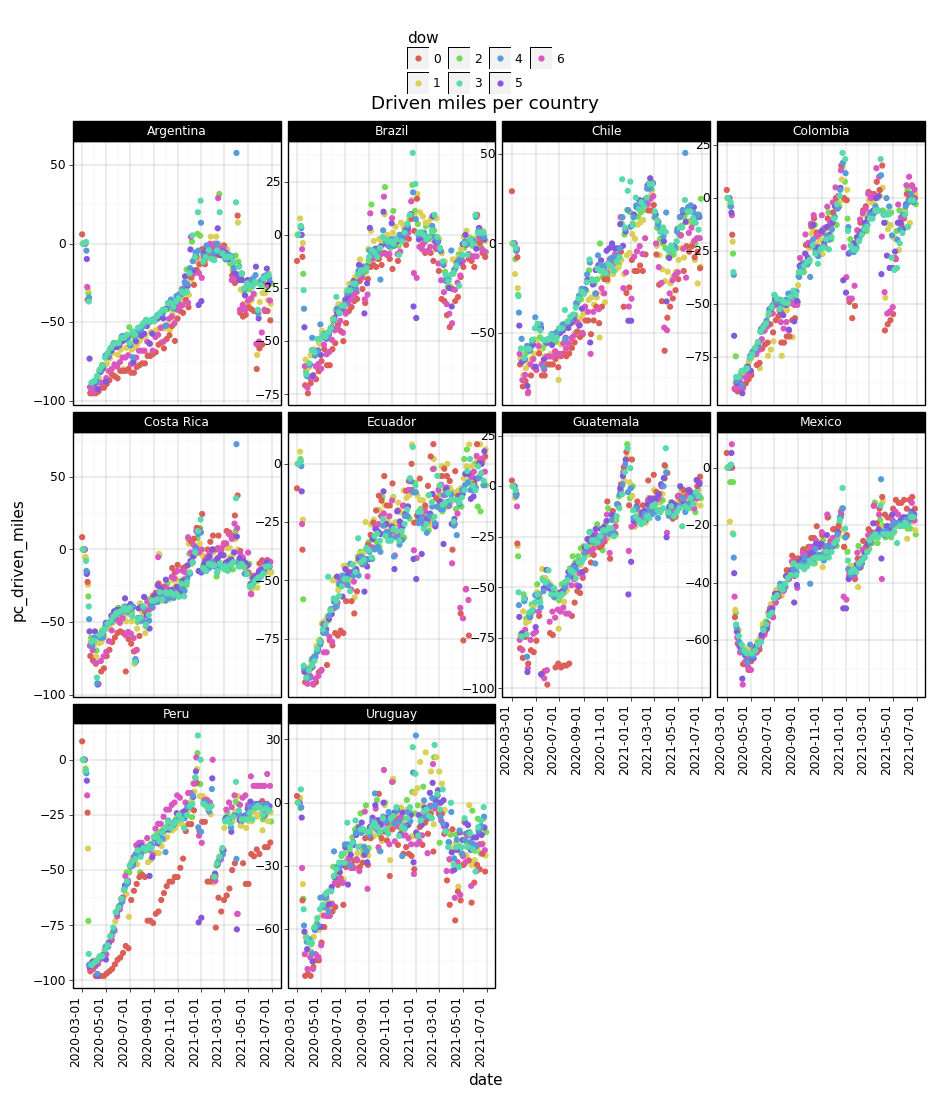

<ggplot: (8772859612869)>

In [23]:
gg2

In [24]:
df_waze.head(2)

,country,date,pc_driven_miles,dow
0,Argentina,2021-06-29,-25.316456,2
1,Argentina,2021-06-22,-18.987342,2


#### Google mobility

In [25]:
df_goo = pd.read_csv("~/shared/spd-sdv-omitnik-waze/corona/mobility/Global_Mobility_Report.csv")  
df_goo = df_goo[df_goo.date != '-5']

In [26]:
df_goo['inregion'] = df_goo.country_region_code.isin(iso_codes.country_iso_code.to_list())
df_goo['date'] = df_goo.date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
df_goo = df_goo \
    .siu_filter(_.inregion) \
    .siu_filter( _.sub_region_1.isnull(), _.metro_area.isnull())   
print(df_goo.shape)


(9451, 16)


In [27]:
tab = (df_goo 
 >> group_by('country_region_code', 'country_region')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
#tab

In [28]:
#df_goo[(df_goo.date == '2020-03-09') & (df_goo.country_region_code == 'AR')]

In [29]:
print(len(df_goo.country_region_code.unique()))
df_goo.country_region_code.unique()

20


array(['AR', 'BB', 'BO', 'BR', 'CL', 'CO', 'CR', 'DO', 'EC', 'GT', 'HN',
       'JM', 'MX', 'NI', 'PA', 'PE', 'PY', 'SV', 'TT', 'UY'], dtype=object)

In [30]:
#df_goo.dtypes
#df_goo.columns

Turn baseline from 2020-03-02 to 2020-03-08 per day of week

In [31]:
df_goo = df_goo \
              .siu_select('country_region_code', 'date', 
                          'transit_stations_percent_change_from_baseline',
                          'workplaces_percent_change_from_baseline') \
            .siu_mutate(transit_stations_percent_change_from_baseline = (_.transit_stations_percent_change_from_baseline + 100 ),
                       workplaces_percent_change_from_baseline = (_.workplaces_percent_change_from_baseline + 100 ))      
df_goo['dow'] = df_goo.date.apply(lambda x : datetime.datetime.strftime(x, '%w'))  

In [32]:
#df_goo[(df_goo.dow == '0') & (df_goo.country_region_code == 'AR') & (df_goo.date >= '2020-03-02')][0:50]

In [33]:
df_goo_base = df_goo[(df_goo.date >= '2020-03-09') & (df_goo.date <= '2020-03-15')] \
    .drop('date', 1) \
    .rename(columns = {'transit_stations_percent_change_from_baseline':'transit_baseline',
                      'workplaces_percent_change_from_baseline':'workplace_baseline'})
df_goo_base.head(2)
df_goo_base[(df_goo_base.country_region_code == 'AR') ]

,country_region_code,transit_baseline,workplace_baseline,dow
8441,AR,113.0,115.0,1
8442,AR,114.0,118.0,2
8443,AR,94.0,115.0,3
8444,AR,110.0,118.0,4
8445,AR,107.0,118.0,5
8446,AR,81.0,96.0,6
8447,AR,83.0,90.0,0


In [34]:
df_goo_rebase = df_goo.merge(df_goo_base)
df_goo_rebase['transit_stations_percent_change_from_baseline_rb'] = 100*(df_goo_rebase['transit_stations_percent_change_from_baseline']-df_goo_rebase['transit_baseline'])/df_goo_rebase['transit_baseline']
df_goo_rebase['workplaces_percent_change_from_baseline_rb'] = 100*(df_goo_rebase['workplaces_percent_change_from_baseline']- df_goo_rebase['workplace_baseline'])/df_goo_rebase['workplace_baseline']
df_goo_rebase.head()
df_goo = df_goo_rebase.drop(['workplace_baseline', 'transit_baseline'], 1)


In [35]:
print(df_goo_rebase.shape)
#df_goo_rebase[(df_goo_rebase.date >= '2020-03-09')  & (df_goo_rebase.date <= '2020-03-15') & (df_goo_rebase.country_region_code == 'AR')]

(10390, 9)


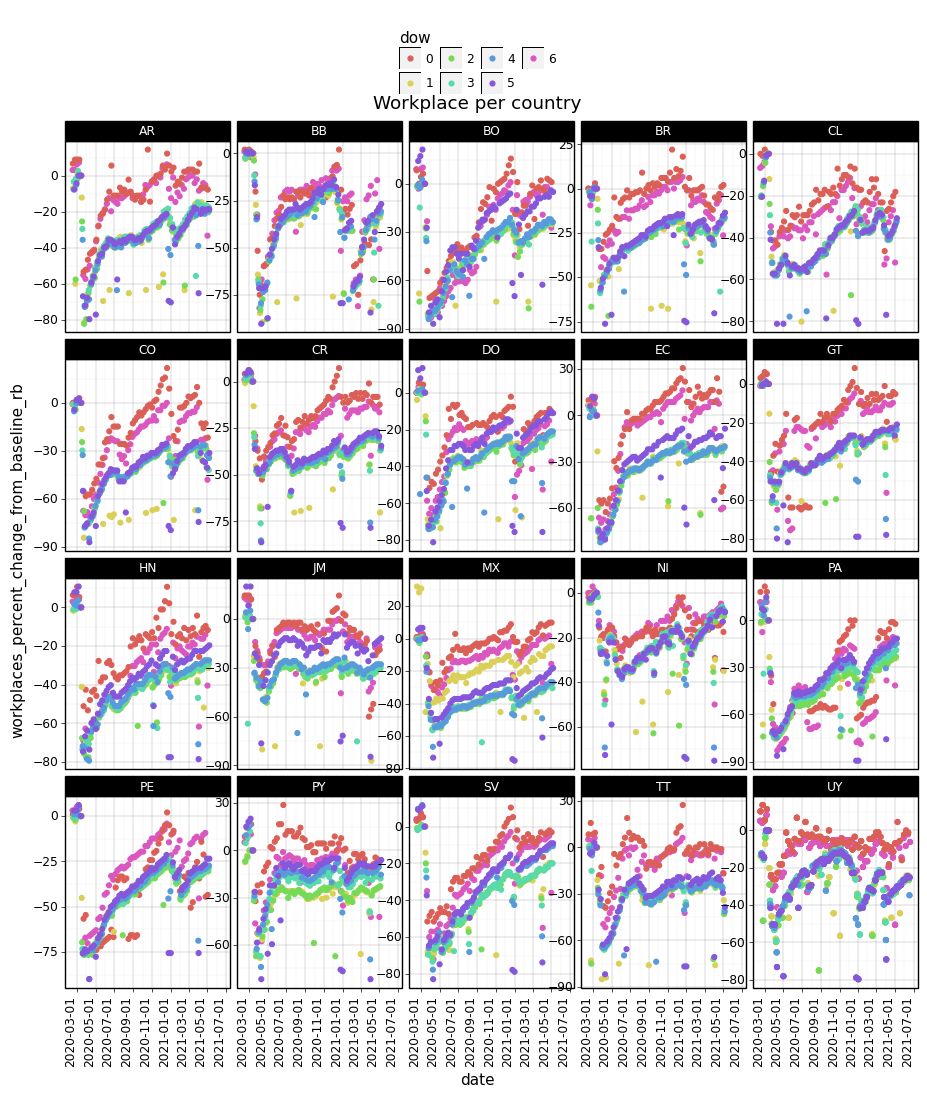

<ggplot: (8772859160165)>


In [36]:
gg1 = (p9.ggplot(df_goo_base, 
           p9.aes(x='dow', y ='workplace_baseline')) 
 + p9.geom_point()
 + p9.facet_wrap('country_region_code', scales='free_y') 
 + p9.labs(title='Workplace per country for base period')
 + p9.theme(figure_size = (11, 11),
            axis_text_x=p9.element_text(rotation=90, hjust=1), 
            legend_position='top')
) 
gg2 = (p9.ggplot(df_goo, 
           p9.aes(x='date', y ='workplaces_percent_change_from_baseline_rb', color = 'dow')) 
 + p9.geom_point()
 + p9.facet_wrap('country_region_code', scales='free_y') 
 + p9.labs(title='Workplace per country')
 + p9.theme(figure_size = (11, 11),
            axis_text_x=p9.element_text(rotation=90, hjust=1), 
            legend_position='top')
) 
print(gg2)

In [37]:
df_goo[(df_goo.date >= '2020-03-09') & (df_goo.date <= '2020-03-15') & (df_goo.country_region_code == 'AR')]

,country_region_code,date,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,dow,transit_stations_percent_change_from_baseline_rb,workplaces_percent_change_from_baseline_rb
4,AR,2020-03-14,81.0,96.0,6,0.0,0.0
68,AR,2020-03-15,83.0,90.0,0,0.0,0.0
131,AR,2020-03-09,113.0,115.0,1,0.0,0.0
195,AR,2020-03-10,114.0,118.0,2,0.0,0.0
259,AR,2020-03-11,94.0,115.0,3,0.0,0.0
323,AR,2020-03-12,110.0,118.0,4,0.0,0.0
387,AR,2020-03-13,107.0,118.0,5,0.0,0.0


### Comparison

In [38]:
df = (df_dash \
     .siu_select('region_slug', 'country_name', 'country_iso_code', 'date', 'tcp') 
 >> left_join(_, 
          df_waze \
              .siu_select('country', 'date', 'pc_driven_miles') \
              .siu_rename(country_name='country'), 
              on=['country_name', 'date']) 
 >> left_join(_, 
          df_goo \
              .siu_select('country_region_code', 'date', 
                          'transit_stations_percent_change_from_baseline_rb',
                          'workplaces_percent_change_from_baseline_rb') \
              .siu_rename(country_iso_code='country_region_code',
                          workplace='workplaces_percent_change_from_baseline_rb',
                          transit='transit_stations_percent_change_from_baseline_rb'), 
              on=['country_iso_code', 'date'])
# >> left_join(_, 
#         df_max \
#              .siu_select('date', 'region_slug', 'tcp_clean'),
#              on=['region_slug', 'date'])
 >> gather('measure', 'value', _["tcp", "pc_driven_miles", 'workplace', "transit", 'tcp']) 
)
df.dtypes
df.head(2)

,region_slug,country_name,country_iso_code,date,measure,value
0,country_chile,Chile,CL,2020-06-06,tcp,-60.958384
1,country_chile,Chile,CL,2020-03-14,tcp,-4.796211


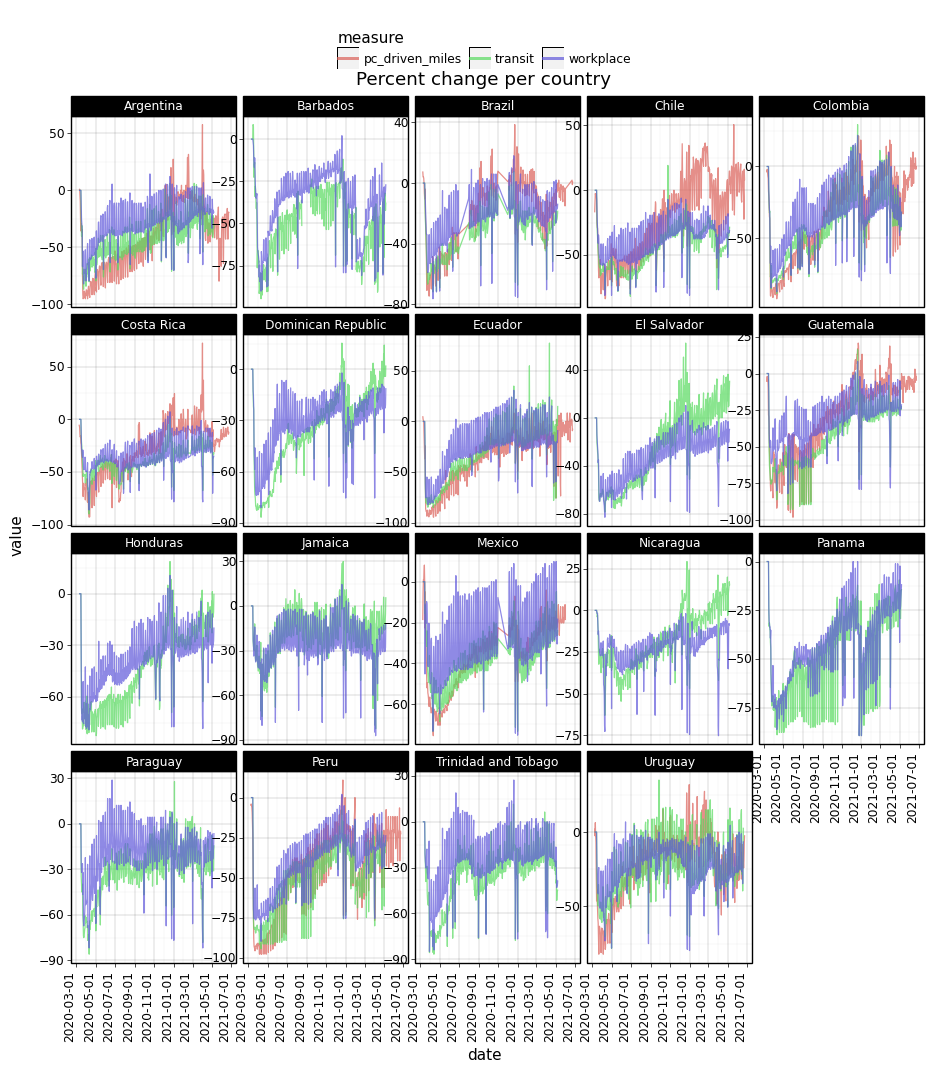

<ggplot: (8772848642589)>

In [39]:
(p9.ggplot(df.siu_filter(_.measure != 'tcp',
                        #_.measure != 'transit',
                         #_.date >= '2020-03-09',
                         #_.date <= '2020-03-16'
                        ), 
           p9.aes(x='date', y ='value', color = 'measure')) 
 + p9.geom_line(alpha = .7)
 + p9.facet_wrap('country_name', scales='free_y') 
 + p9.labs(title='Percent change per country')
 + p9.theme(figure_size = (11, 11),
            axis_text_x=p9.element_text(rotation=90, hjust=1), 
            legend_position='top')
) 

In [40]:
#df.siu_filter(_.country_name=='Mexico', _.measure == 'tcp').head()

In [41]:
df_country = df

### Plots per data source

In [ ]:
df_goo[['date', 'transit_stations_percent_change_from_baseline', 'country_region']] \
    .pivot(index='date', columns='country_region', values='transit_stations_percent_change_from_baseline') \
    .iplot(
    #theme='custom',
    yTitle='% Change',
    title='Google mobility - PC Transit stations'
)

In [ ]:
df_dash[['date', 'tcp', 'region_slug']] \
    .pivot(index='date', columns='region_slug', values='tcp') \
    .iplot(
    #theme='custom',
    yTitle='% Change',
    title='Waze IDB dashboard - TCP'
)

In [ ]:
df_waze[['date', 'pc_driven_miles', 'country']] \
    .pivot(index='date', columns='country', values='pc_driven_miles') \
    .iplot(
    #theme='custom',
    yTitle='% Change',
    title='Waze public - PC driven miles'
)

## City level

### Load data (city level)

In [ ]:
cities_names = (pd.read_csv('../docs/city_names_dictionary.csv') 
    >> filter(_.country_iso_code__dash.isnull() == False)
)
cities_names.head(2)

#### Waze dashboard

In [42]:
df_dash = pd.read_sql_query("""
select 
    *,
    (date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e')) as date
from spd_sdv_waze_corona.prod_daily_daily_index
where region_type = 'city';
""", conn)

In [43]:
df_dash.shape

(29249, 20)

In [44]:
tab = (df_dash 
 >> group_by('country_iso_code', 'country_name', 'region_slug', 'region_name')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
tab.to_csv('~/private/projects/dash_mob_city_list.csv')
tab

,country_iso_code,country_name,region_slug,region_name,min_date,max_date,n_obs
0,AR,Argentina,buenosaires,Buenos Aires,2020-03-09,2021-06-23,472
1,AR,Argentina,cordoba,Córdoba,2020-03-09,2021-06-23,472
2,AR,Argentina,rosario,Rosario,2020-03-09,2021-06-23,472
3,BO,Bolivia,santacruzdelasierra,Santa Cruz de la Sierra,2020-03-09,2021-06-23,472
4,BR,Brazil,belem,Belém,2020-03-09,2021-06-23,472
...,...,...,...,...,...,...,...
57,PA,Panama,panamacity,Ciudad de Panamá,2020-03-09,2021-06-23,472
58,PE,Peru,arequipa,Arequipa,2020-03-09,2021-06-23,472
59,PE,Peru,lima,Lima,2020-03-09,2021-06-23,472
60,SV,El Salvador,sansalvador,San Salvador,2020-03-09,2021-06-23,465


In [45]:
print(len(df_dash.region_name.unique())) # Bolivia is missing
df_dash.sort_values('region_name').region_name.unique()
df_dash.sort_values('region_slug').region_slug.unique()

62


array(['aguascalientes', 'arequipa', 'barranquilla', 'belem',
       'belohorizonte', 'bogota', 'brasilia', 'bucaramanga',
       'buenosaires', 'cali', 'campinas', 'cartagena', 'cordoba',
       'cucuta', 'cuenca', 'curitiba', 'fortaleza', 'goiania',
       'guadalajara', 'guatemala', 'guayaquil', 'joaopessoa', 'kingston',
       'leon', 'lima', 'maceio', 'managua', 'manaus', 'medellin',
       'merida', 'mexicocity', 'monterrey', 'montevideo', 'natal',
       'panamacity', 'pereira', 'porto_alergre', 'pueble', 'queretaro',
       'quito', 'recife', 'riodejaneiro', 'rosario', 'salvador',
       'sanjose', 'sanluispotosi', 'sansalvador', 'santacruzdelasierra',
       'santamarta', 'santiago', 'santiagocaballeros', 'santodomingo',
       'santos', 'saojosedoscampos', 'saoluis', 'saopaulo', 'sorocaba',
       'tegucigalpa', 'teresina', 'toluca', 'torreon', 'vitoria'],
      dtype=object)

#### TCP Fixed

In [46]:
#df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max.csv")
#df_max['exists'] = df_max.region_slug.isin(df_dash.region_slug.unique().tolist()) 
#df_max['date'] = df_max.date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
#df_max = df_max.siu_filter(_.exists)

In [47]:
#df_max.head()

#### Waze driven km

In [48]:
df_waze = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/Waze _ COVID-19 Impact Dashboard_City-Level Data_Table.csv")
df_waze.sort_values('Country').Country.unique()


array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Canada', 'Chile',
       'Colombia', 'Costa Rica', 'Czechia', 'Ecuador', 'France',
       'Germany', 'Hungary', 'Indonesia', 'Israel', 'Italy', 'Latvia',
       'Lithuania', 'Malaysia', 'Mexico', 'Netherlands', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania',
       'Singapore', 'Slovakia', 'South Africa', 'Spain', 'Sweden',
       'Ukraine', 'United Kingdom', 'United States', 'Uruguay'],
      dtype=object)

In [49]:
df_waze = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/Waze _ COVID-19 Impact Dashboard_City-Level Data_Table.csv")
df_waze.columns = ['date', 'city', 'country', 'pc_driven_miles']
df_waze['date'] = df_waze.date.apply(lambda x : datetime.datetime.strptime(x, '%b %d, %Y'))
df_waze['exists'] = df_waze.country.isin([ 'Argentina','Brazil', 'Chile', 'Colombia', 'Costa Rica',  
                                          'Ecuador', 'Guatemala',  'Mexico',  'Peru', 'Uruguay']) 
df_waze = df_waze.siu_filter(_.exists).siu_mutate(pc_driven_miles=100*(_.pc_driven_miles+1))      

In [50]:
tab = (df_waze 
 >> group_by('country', 'city')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
tab.to_csv('~/private/projects/waze_mob_city_list.csv')
tab.head()

,country,city,min_date,max_date,n_obs
0,Argentina,Buenos Aires,2020-03-01,2021-05-08,475
1,Brazil,Belo Horizonte,2020-03-01,2021-05-08,476
2,Brazil,Brasilia,2020-03-01,2021-05-08,475
3,Brazil,Curitiba,2020-03-01,2021-05-08,476
4,Brazil,Florianopolis,2020-03-01,2021-05-08,475


In [51]:
print(len(df_waze.city.unique())) # Bolivia is missing
df_waze.sort_values('city').city.unique()

29


array(['Belo Horizonte', 'Bogota', 'Brasilia', 'Buenos Aires', 'Cali',
       'Curitiba', 'Florianopolis', 'Fortaleza', 'Guadalajara',
       'Guarulhos', 'Las Condes', 'Lima', 'Maipu', 'Medellin',
       'Mexico City', 'Monterrey', 'Montevideo', 'Porto Alegre',
       'Puebla City', 'Quito', 'Recife', 'Rio De Janeiro', 'Salvador',
       'San Jose', 'Santiago', 'Santiago De Queretaro', 'Sao Paulo',
       'Vitoria', 'Zapopan'], dtype=object)

In [52]:
df_waze.head(3)

,date,city,country,pc_driven_miles,exists
0,2021-05-08,Cali,Colombia,27.0,True
5,2021-05-08,Quito,Ecuador,51.0,True
8,2021-05-08,Florianopolis,Brazil,52.0,True


Turn baseline from 2020-03-02 to 2020-03-08 per day of week

In [53]:
df_waze = df_waze \
              .siu_select('city', 'country', 'date', 
                          'pc_driven_miles')
df_waze['dow'] = df_waze.date.apply(lambda x : datetime.datetime.strftime(x, '%w'))  
df_waze.head(2)

,city,country,date,pc_driven_miles,dow
0,Cali,Colombia,2021-05-08,27.0,6
5,Quito,Ecuador,2021-05-08,51.0,6


In [54]:
df_waze_base = df_waze[(df_waze.date >= '2020-03-02') & (df_waze.date <= '2020-03-08')] \
    .drop('date', 1) \
    .rename(columns = {'pc_driven_miles':'pc_driven_miles_baseline'})
df_waze_base.head(2)

,city,country,pc_driven_miles_baseline,dow
60289,Vitoria,Brazil,67.0,0
60291,Florianopolis,Brazil,75.0,0


In [55]:
df_waze_rebase = df_waze.merge(df_waze_base)
df_waze_rebase['pc_driven_miles'] = 100*(df_waze_rebase['pc_driven_miles']- df_waze_rebase['pc_driven_miles_baseline'])/df_waze_rebase['pc_driven_miles_baseline']
print(df_waze.shape)
print(df_waze_rebase.shape)
df_waze_rebase.head()
df_waze = df_waze_rebase.drop(['pc_driven_miles_baseline'], 1)

(13778, 5)
(27556, 6)


In [56]:
df_waze.head(2)

,city,country,date,pc_driven_miles,dow
0,Cali,Colombia,2021-05-08,-74.528302,6
1,Cali,Colombia,2021-05-08,-74.528302,6


#### Google mobility

In [57]:
df_goo = pd.read_csv("~/shared/spd-sdv-omitnik-waze/corona/mobility/Global_Mobility_Report.csv")  


In [58]:
df_goo['inregion']=df_goo.country_region_code.isin(iso_codes.country_iso_code.to_list())
df_goo['date'] = df_goo.date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
df_goo = df_goo \
    .siu_filter(_.inregion) \
    .siu_filter( _.sub_region_1.isnull()==False)#, _.metro_area.isnull())
df_goo.sub_region_2=df_goo.sub_region_2.fillna('None')
df_goo.metro_area=df_goo.metro_area.fillna('None')
print(df_goo.shape)

ValueError: time data '-5' does not match format '%Y-%m-%d'

In [ ]:
tab = (df_goo 
 >> group_by('country_region_code', 'country_region', 'sub_region_1', 'sub_region_2', 'metro_area')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
tab.to_csv('~/private/projects/google_mob_city_list.csv')
tab.head(2)

In [ ]:
df_goo.head(2)

In [ ]:
tab.shape

In [ ]:
df_goo = df_goo \
              .siu_select('country_region_code', 'country_region',
                          'sub_region_1', 'sub_region_2', 
                          'date', 
                          'transit_stations_percent_change_from_baseline',
                          'workplaces_percent_change_from_baseline') \
            .siu_mutate(transit_stations_percent_change_from_baseline = (_.transit_stations_percent_change_from_baseline + 100 ),
                       workplaces_percent_change_from_baseline = (_.workplaces_percent_change_from_baseline + 100 ))      
df_goo['dow'] = df_goo.date.apply(lambda x : datetime.datetime.strftime(x, '%w'))  

In [ ]:
df_goo_base = df_goo[(df_goo.date >= '2020-03-09') & (df_goo.date <= '2020-03-15')] \
    .drop('date', 1) \
    .rename(columns = {'transit_stations_percent_change_from_baseline':'transit_baseline',
                      'workplaces_percent_change_from_baseline':'workplace_baseline'})
df_goo_base.head(2)
#df_goo_base[(df_goo_base.country_region_code == 'AR') ]

In [ ]:
df_goo_rebase = df_goo.merge(df_goo_base)
df_goo_rebase['transit_stations_percent_change_from_baseline_rb'] = 100*(df_goo_rebase['transit_stations_percent_change_from_baseline']-df_goo_rebase['transit_baseline'])/df_goo_rebase['transit_baseline']
df_goo_rebase['workplaces_percent_change_from_baseline_rb'] = 100*(df_goo_rebase['workplaces_percent_change_from_baseline']- df_goo_rebase['workplace_baseline'])/df_goo_rebase['workplace_baseline']
print(df_goo.shape)
print(df_goo_rebase.shape)
df_goo_rebase.head()
df_goo = df_goo_rebase.drop(['workplace_baseline', 'transit_baseline'], 1)


### Comparison

Comparing all sources per region slug.

In [ ]:
df_goo.head(1)

In [ ]:
cities_names.head()

In [ ]:
df=df_dash \
.siu_select('country_iso_code', 'country_name', 'region_slug', 'region_name', 'date', 'tcp') \
.add_suffix('__dash') \
.merge(cities_names, how='inner') \
.merge(df_waze.add_suffix('__waze'), 
       how='left', 
       left_on=['country__waze','city__waze', 'date__dash'],
       right_on = ['country__waze','city__waze', 'date__waze']) \
.merge(df_goo.add_suffix('__goo'), 
       how='left', 
       left_on=['country_region_code__goo','country_region__goo', 
                'sub_region_1__goo', 'sub_region_2__goo', 'date__dash'],
       right_on =['country_region_code__goo','country_region__goo', 
               'sub_region_1__goo', 'sub_region_2__goo', 'date__goo']) \
.siu_rename(transit__goo='transit_stations_percent_change_from_baseline_rb__goo',
           workplace__goo='workplaces_percent_change_from_baseline_rb__goo') \
.siu_select('country_iso_code__dash', 'country_name__dash', 'region_slug__dash', 
        'date__dash', 'tcp__dash', 'pc_driven_miles__waze',
           'transit__goo', 'workplace__goo') \
.siu_gather('measure', 'value', _["tcp__dash":"workplace__goo"]) 



In [ ]:
print(df.shape)

In [ ]:
print(df_dash.shape)
print(df_waze.shape)
print(df_goo.shape)
print(df.shape)
df.country_iso_code__dash.unique()

In [ ]:
(p9.ggplot(df.siu_filter(_.country_iso_code__dash == 'MX', _.value <100), 
           p9.aes(x='date__dash', y ='value', color = 'measure')) 
 + p9.geom_line()
 + p9.facet_wrap(['country_iso_code__dash', 'region_slug__dash'], scales='free_y', ncol= 3) 
 + p9.theme(figure_size = (10, 10),
            axis_text_x=p9.element_text(rotation=90, hjust=1), 
            legend_position='top')
 + p9.labs(title='Observed measure per city')
) 

In [ ]:
df_region=df

#### Rescaled percentage change to common week 2020-03-23

Modified baseline: avergae percentage for the week period from March 23th, 2020 to March 29th, 2020. 

In [61]:
df_mean = (df
 >> filter(_.date__dash >= '2020-03-02', _.date__dash <= '2020-03-08')
 >> group_by('region_slug__dash', 'measure')
 >> summarize(mean_val = _.value.mean())
 >> ungroup()
)
df_re = (df.merge(df_mean.reset_index(), on=['region_slug__dash', 'measure'], how='left')
 >> mutate(value_rescaled = -100*_.value/_.mean_val)
)
df_re.country_iso_code__dash.unique()

AttributeError: 'DataFrame' object has no attribute 'date__dash'

In [ ]:
(p9.ggplot(df_re.siu_filter(_.country_iso_code__dash == 'MX', 
                            #_.region_slug__dash =='mexicocity',
                            #_.value_rescaled < 300,
                            #_.measure!='workplace__goo', _.measure!='transit__goo',
                            # _.date__dash >= '2020-11-01', _.date__dash < '2020-12-01'
                           ), 
           p9.aes(x='date__dash', y ='value_rescaled', color = 'measure')) 
 + p9.geom_line()
 + p9.facet_wrap(['country_iso_code__dash', 'region_slug__dash'], scales='free_y', ncol= 3) 
 + p9.labs(title='Rescaled baseline')
 + p9.theme(figure_size = (10, 10),
            axis_text_x=p9.element_text(rotation=90, hjust=1), 
            legend_position='top')
) 

#### Moving average smoothing

Rolling average with previous seven days.

In [ ]:
df_sao = df_re.siu_filter(_.country_iso_code__dash == 'MX', 
                            #_.region_slug__dash =='riodejaneiro',
                            #_.value_rescaled < 300,
                            #_.measure!='workplace__goo', _.measure!='transit__goo',
                            # _.date__dash >= '2020-11-01', _.date__dash < '2020-12-01'
                           )
#df_sao.head()

In [ ]:
df_ma = (df_sao
 >> arrange('region_slug__dash', 'measure', 'date__dash')
 >> group_by('region_slug__dash', 'measure')
 >> mutate(value_rescaled_ma = _.value_rescaled.rolling(7).mean())
 >> ungroup()
)
df_ma.head()

In [ ]:
(p9.ggplot(df_ma, 
           p9.aes(x='date__dash', y ='value_rescaled_ma', color = 'measure')) 
 + p9.geom_line()
 + p9.facet_wrap(['country_iso_code__dash', 'region_slug__dash'], scales='free_y', ncol= 3)
 + p9.labs(title='Ppercent change smooth')
 + p9.theme(figure_size = (10, 10),
            axis_text_x=p9.element_text(rotation=90, hjust=1), 
            legend_position='top')
) 

In [ ]:
#df.siu_filter(_.region_slug__dash=='arequipa', _.date__dash >= '2020-03-23', _.date__dash <= '2020-03-29').value
#df_mean.siu_filter(_.region_slug__dash=='arequipa')
#df_waze.siu_filter(_.city=='Arequipa', _.date >= '2020-03-23', _.date <= '2020-03-29')

## Country + City

#### create DF union

In [60]:
df_union = pd.concat([df_country, 
                     df_region.rename(columns={'country_iso_code__dash':'country_iso_code',
                          'country_name__dash':'country_name',
                          'region_slug__dash':'region_slug',
                          'date__dash':'date'})])
print(df.shape)
df_union.head()

NameError: name 'df_region' is not defined

In [ ]:
df_union.measure[df_union.measure == 'pc_driven_miles'] = 'pc_driven_miles__waze'
df_union.measure[df_union.measure == 'tcp'] = 'tcp__dash'
df_union.measure[df_union.measure == 'transit'] = 'transit__goo'
df_union.measure[df_union.measure == 'workplace'] = 'workplace__goo'

In [ ]:
df_union.measure.unique()

In [ ]:
df_union.siu_spread("measure", "value").to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/region_city_union.csv")


In [ ]:
len(df_union.region_slug.unique())

#### Read data frame union

In [ ]:
#df_union.siu_spread("measure", "value").to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/region_city_union.csv")
df_union = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/region_city_union.csv").drop('Unnamed: 0', axis=1)
df_union.head()

In [ ]:
df_union.describe()

reading daily data

In [ ]:
df_mobility = df_union#.siu_spread("measure", "value")
df_mobility['date'] = df_mobility.date.astype(str)

#df_daily = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max.csv")
#df_daily = df_max[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
#    .rename(columns = {'tci_clean':'tci_cleaned', 
#                       'tcp_clean':'tcp_cleaned'}) 

df_daily = pd.read_csv("/home/soniame/private/daily_index_index.csv")
df_daily.head()

In [ ]:
print(df_daily.columns)
print(df_mobility.columns)

In [ ]:
df_mobility_clean = df_daily.merge(df_mobility, 
                                 how = 'left')
df_mobility_clean.head(2)

In [ ]:
print(df_union.shape)
print(df_mobility.shape)
print(df_daily.shape)
print(df_mobility_clean.shape)

In [59]:
print(sum(df_mobility_clean.pc_driven_miles__waze.isna())/len(df_mobility_clean.tcp__dash))
print(sum(df_mobility_clean.transit__goo.isna())/len(df_mobility_clean.tcp__dash))
print(sum(df_mobility_clean.workplace__goo.isna())/len(df_mobility_clean.tcp__dash))
print(sum(df_mobility_clean.tcp__dash.isna())/len(df_mobility_clean.tcp__dash))
df_mobility_clean.head(2)

NameError: name 'df_mobility_clean' is not defined

In [ ]:
df_mobility_clean.to_csv("/home/soniame/private/smooth/daily_index_index_movility.csv")

In [ ]:
df_mobility_clean[df_mobility_clean.workplace__goo.isna() == False].region_slug.unique()

In [ ]:
print(len(df_mobility_clean[df_mobility_clean.workplace__goo.isna() == False].region_slug.unique()))
df_mobility_clean[df_mobility_clean.workplace__goo.isna() == False].region_slug.unique()

In [ ]:
print(len(df_mobility_clean[df_mobility_clean.pc_driven_miles__waze.isna() == False].region_slug.unique()))
df_mobility_clean[df_mobility_clean.pc_driven_miles__waze.isna() == False].region_slug.unique()


In [ ]:
df_mobility_clean.head(2)

In [ ]:
(p9.ggplot(df_mobility_clean.siu_filter(_.region_slug =='country_mexico'), 
           p9.aes(x='date', y ='tcp_observed', group= 'region_slug')) 
 + p9.geom_line()
 + p9.geom_line(p9.aes(y = 'tcp_cleaned'), color = 'gray')
 + p9.geom_line(p9.aes(y = 'tcp_cleaned_ls_20X'), color = 'red')
 + p9.geom_line(p9.aes(y = 'tcp_cleaned_ls_10X'), color = 'orange')
 +  p9.geom_line(p9.aes(y = 'tcp_cleaned_ls_15X'), color = 'blue')
 + p9.geom_line(p9.aes(y = 'tcp_cleaned_ls_OFF'), color = 'green')
 #+ p9.geom_line(p9.aes(y = 'workplace__goo'), color = 'red')
 #+ p9.geom_line(p9.aes(y = 'pc_driven_miles__waze'), color = 'blue')
 + p9.facet_wrap(['region_slug'], scales='free_y', ncol= 3) 
 + p9.labs(title='Mobility')
 + p9.theme(figure_size = (10, 6),
            axis_text_x=p9.element_text(rotation=90, hjust=1, size = 3), 
            legend_position='top')
) 

#### Daily in long format

In [ ]:
df_daily_long = (df_mobility_clean 
 >> select('date', 'region_slug', 
           'tci_observed',  'tci_cleaned', 
           'tci_cleaned_ls_4X', 'tci_cleaned_ls_20X', 
           'tci_cleaned_ls_10X', 'tci_cleaned_ls_15X',
           'tci_cleaned_ls_OFF', 'tci_cleaned_ls_MIX',
           'tcp_observed', 'tcp_cleaned', 
           'tcp_cleaned_ls_4X', 'tcp_cleaned_ls_20X', 
           'tcp_cleaned_ls_OFF', 'tcp_cleaned_ls_MIX', 
           'tci_cleaned_ls_10X', 'tci_cleaned_ls_15X',
           'pc_driven_miles__waze',
           'workplace__goo')
 >> gather('measure', 'value', _["tci_observed":"workplace__goo"])
)

df_daily_long['type'] = 'TCP'
tci_exist = df_daily_long['measure'].isin(['tci_observed',  'tci_cleaned', 
           'tci_cleaned_ls_4X', 'tci_cleaned_ls_20X', 
           'tci_cleaned_ls_10X', 'tci_cleaned_ls_15X',
           'tci_cleaned_ls_OFF', 'tci_cleaned_ls_MIX'])
df_daily_long['type'][tci_exist] = 'TCI'

print(df_daily_long.type.unique())
print(df_daily_long.measure.unique())
head(df_daily_long)

In [ ]:
df_daily_long.to_csv("/home/soniame/private/daily_daily_index_long.csv")